In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'JBLU Variation 6 CNN Images Experiment'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Jet Blue Stock Data

### No other stock price

In [5]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2002-05-02,14.761481,13.724947,-5.141986,58104336.0,2.0
2002-05-03,14.562963,13.853872,-13.413429,57315261.0,2.0
2002-05-06,15.419259,14.094701,-0.086583,58757399.0,0.0
2002-05-07,16.148148,14.410616,-4.436861,61163774.0,2.0
2002-05-08,14.696296,14.454567,-37.883964,57784724.0,2.0


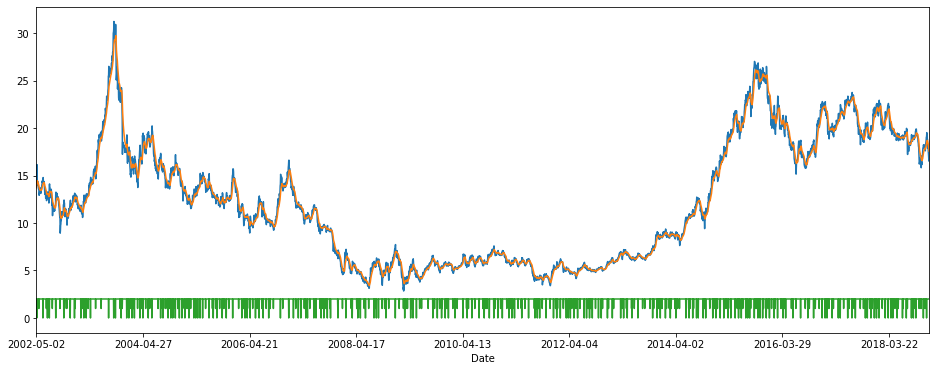

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [8]:
willr_data = np.array(willr_data)
willr_data.shape

(4175, 15, 1)

In [9]:
price_data = np.array(price_data)
price_data.shape

(4175, 15, 1)

In [10]:
ema_data = np.array(ema_data)
ema_data.shape

(4175, 15, 1)

In [11]:
obv_data = np.array(obv_data)
obv_data.shape

(4175, 15, 1)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [13]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4175, 64, 64, 1)

In [14]:
from collections import Counter

Counter(y)

Counter({2.0: 3801, 0.0: 191, 1.0: 183})

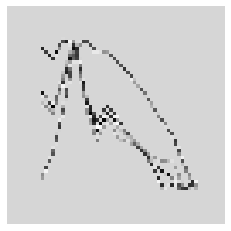

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.276688453159041, 1: 7.6255707762557075, 2: 0.3661076400306917}
Epoch 1/200
 1/27 [>.............................] - ETA: 0s - loss: 0.3984 - accuracy: 0.6875 - mse: 5.5141 - weighted_accuracy: 0.3702 - weighted_mse: 5.5243WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
27/27 [==============================] - 1s 23ms/step - loss: 0.2492 - accuracy: 0.3204 - mse: 1.6919 - weighted_accuracy: 0.3244 - weighted_mse: 1.6947 - val_loss: 0.1894 - val_accuracy: 0.5102 - val_mse: 1.0867 - val_weighted_accuracy: 0.5102 - val_weighted_mse: 1.0867
Epoch 2/200
27/27 [==============================] - 0s 9ms/step - loss: 0.2111 - accuracy: 0.2470 - mse: 1.2565 - weighted_accuracy: 0.3291 - weighted_mse: 1.2693 - val_loss: 0.1859 - val_accuracy: 0.8192 - va

Epoch 27/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1858 - accuracy: 0.2314 - mse: 1.2828 - weighted_accuracy: 0.5158 - weighted_mse: 1.2315 - val_loss: 0.2000 - val_accuracy: 0.1521 - val_mse: 1.0333 - val_weighted_accuracy: 0.1521 - val_weighted_mse: 1.0333
Epoch 28/200
27/27 [==============================] - 0s 10ms/step - loss: 0.1862 - accuracy: 0.2293 - mse: 1.2451 - weighted_accuracy: 0.5088 - weighted_mse: 1.1889 - val_loss: 0.1945 - val_accuracy: 0.1533 - val_mse: 1.1279 - val_weighted_accuracy: 0.1533 - val_weighted_mse: 1.1279
Epoch 29/200
27/27 [==============================] - 0s 10ms/step - loss: 0.1849 - accuracy: 0.2799 - mse: 1.3362 - weighted_accuracy: 0.5185 - weighted_mse: 1.2768 - val_loss: 0.2011 - val_accuracy: 0.1485 - val_mse: 1.1041 - val_weighted_accuracy: 0.1485 - val_weighted_mse: 1.1041
Epoch 30/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1844 - accuracy: 0.2569 - mse: 1.3301 - weighted_accuracy: 0.5012 - we

Epoch 56/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1620 - accuracy: 0.2928 - mse: 1.4361 - weighted_accuracy: 0.6166 - weighted_mse: 1.4417 - val_loss: 0.1884 - val_accuracy: 0.3078 - val_mse: 1.2301 - val_weighted_accuracy: 0.3078 - val_weighted_mse: 1.2301
Epoch 57/200
27/27 [==============================] - 0s 10ms/step - loss: 0.1611 - accuracy: 0.2545 - mse: 1.4331 - weighted_accuracy: 0.6152 - weighted_mse: 1.4275 - val_loss: 0.1920 - val_accuracy: 0.2778 - val_mse: 1.1353 - val_weighted_accuracy: 0.2778 - val_weighted_mse: 1.1353
Epoch 58/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1617 - accuracy: 0.2925 - mse: 1.4200 - weighted_accuracy: 0.6000 - weighted_mse: 1.4166 - val_loss: 0.1995 - val_accuracy: 0.2216 - val_mse: 1.2877 - val_weighted_accuracy: 0.2216 - val_weighted_mse: 1.2877
Epoch 59/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1594 - accuracy: 0.2665 - mse: 1.4511 - weighted_accuracy: 0.6319 - wei

Epoch 85/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1439 - accuracy: 0.3266 - mse: 1.5448 - weighted_accuracy: 0.6695 - weighted_mse: 1.5975 - val_loss: 0.1913 - val_accuracy: 0.2994 - val_mse: 1.3280 - val_weighted_accuracy: 0.2994 - val_weighted_mse: 1.3280
Epoch 86/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1409 - accuracy: 0.3269 - mse: 1.5716 - weighted_accuracy: 0.6931 - weighted_mse: 1.6001 - val_loss: 0.1864 - val_accuracy: 0.3449 - val_mse: 1.3544 - val_weighted_accuracy: 0.3449 - val_weighted_mse: 1.3544
Epoch 87/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1445 - accuracy: 0.3237 - mse: 1.6338 - weighted_accuracy: 0.6807 - weighted_mse: 1.6850 - val_loss: 0.1954 - val_accuracy: 0.2599 - val_mse: 1.2676 - val_weighted_accuracy: 0.2599 - val_weighted_mse: 1.2676
Epoch 88/200
27/27 [==============================] - 0s 9ms/step - loss: 0.1434 - accuracy: 0.3359 - mse: 1.5657 - weighted_accuracy: 0.6985 - weig

Epoch 114/200
27/27 [==============================] - 0s 13ms/step - loss: 0.1198 - accuracy: 0.4898 - mse: 1.8465 - weighted_accuracy: 0.7691 - weighted_mse: 2.1102 - val_loss: 0.1801 - val_accuracy: 0.4539 - val_mse: 1.6042 - val_weighted_accuracy: 0.4539 - val_weighted_mse: 1.6042
Epoch 115/200
27/27 [==============================] - 0s 12ms/step - loss: 0.1236 - accuracy: 0.4725 - mse: 1.8075 - weighted_accuracy: 0.7646 - weighted_mse: 2.0482 - val_loss: 0.1727 - val_accuracy: 0.5186 - val_mse: 1.4194 - val_weighted_accuracy: 0.5186 - val_weighted_mse: 1.4194
Epoch 116/200
27/27 [==============================] - 0s 12ms/step - loss: 0.1244 - accuracy: 0.4868 - mse: 1.6957 - weighted_accuracy: 0.7575 - weighted_mse: 1.9259 - val_loss: 0.1748 - val_accuracy: 0.5114 - val_mse: 1.5673 - val_weighted_accuracy: 0.5114 - val_weighted_mse: 1.5673
Epoch 117/200
27/27 [==============================] - 0s 12ms/step - loss: 0.1262 - accuracy: 0.4853 - mse: 1.8266 - weighted_accuracy: 0.734

Epoch 143/200
27/27 [==============================] - 0s 12ms/step - loss: 0.1080 - accuracy: 0.5530 - mse: 2.1394 - weighted_accuracy: 0.7985 - weighted_mse: 2.7089 - val_loss: 0.1563 - val_accuracy: 0.6323 - val_mse: 1.6711 - val_weighted_accuracy: 0.6323 - val_weighted_mse: 1.6711
Epoch 144/200
27/27 [==============================] - 0s 13ms/step - loss: 0.1079 - accuracy: 0.5710 - mse: 2.0137 - weighted_accuracy: 0.7948 - weighted_mse: 2.5350 - val_loss: 0.1559 - val_accuracy: 0.6371 - val_mse: 1.6299 - val_weighted_accuracy: 0.6371 - val_weighted_mse: 1.6299
Epoch 145/200
27/27 [==============================] - 0s 12ms/step - loss: 0.1064 - accuracy: 0.5608 - mse: 2.1732 - weighted_accuracy: 0.7911 - weighted_mse: 2.7291 - val_loss: 0.1632 - val_accuracy: 0.5844 - val_mse: 1.6247 - val_weighted_accuracy: 0.5844 - val_weighted_mse: 1.6247
Epoch 146/200
27/27 [==============================] - 0s 12ms/step - loss: 0.1101 - accuracy: 0.5518 - mse: 1.9349 - weighted_accuracy: 0.770

Epoch 172/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0923 - accuracy: 0.6766 - mse: 2.5082 - weighted_accuracy: 0.8188 - weighted_mse: 3.5191 - val_loss: 0.1378 - val_accuracy: 0.7198 - val_mse: 1.8458 - val_weighted_accuracy: 0.7198 - val_weighted_mse: 1.8458
Epoch 173/200
27/27 [==============================] - 0s 12ms/step - loss: 0.0933 - accuracy: 0.6524 - mse: 2.5163 - weighted_accuracy: 0.8224 - weighted_mse: 3.4763 - val_loss: 0.1482 - val_accuracy: 0.6850 - val_mse: 1.9037 - val_weighted_accuracy: 0.6850 - val_weighted_mse: 1.9037
Epoch 174/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0918 - accuracy: 0.6557 - mse: 2.5286 - weighted_accuracy: 0.8149 - weighted_mse: 3.5243 - val_loss: 0.1261 - val_accuracy: 0.7892 - val_mse: 2.0477 - val_weighted_accuracy: 0.7892 - val_weighted_mse: 2.0477
Epoch 175/200
27/27 [==============================] - 0s 13ms/step - loss: 0.0915 - accuracy: 0.6647 - mse: 2.4793 - weighted_accuracy: 0.814

In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12049679458141327
Test accuracy: 0.796407163143158


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.041787   -1.9284418   0.13712402]
 [-1.1950849  -1.1304566   0.13759574]
 [-0.6694935  -2.792768   -0.11336683]
 ...
 [-1.2584617  -1.4211372   0.13433188]
 [-0.01035386 -2.6589644  -0.6011538 ]
 [-0.63623524 -2.1396675  -0.11046411]]


Counter({2: 730, 0: 69, 1: 36})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 760, 1: 37, 0: 38})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) 

number of predictions: 835
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 35
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 34
actual holds but predicted buy: 34
actual holds but predicted sell: 65
actual predicted holds: 661
Percentage buys correct: 2.7027027027027026%
Percentage sells correct: 7.894736842105263%
Percentage holds correct: 86.97368421052632%
actual buys: 37
actual sells: 38
actual holds: 760


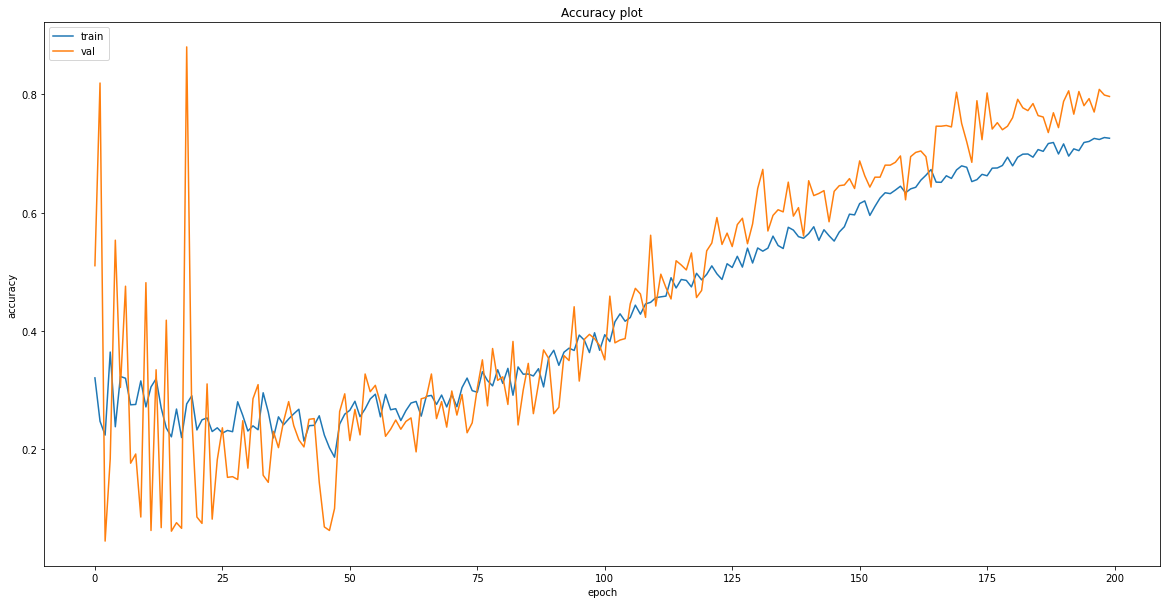

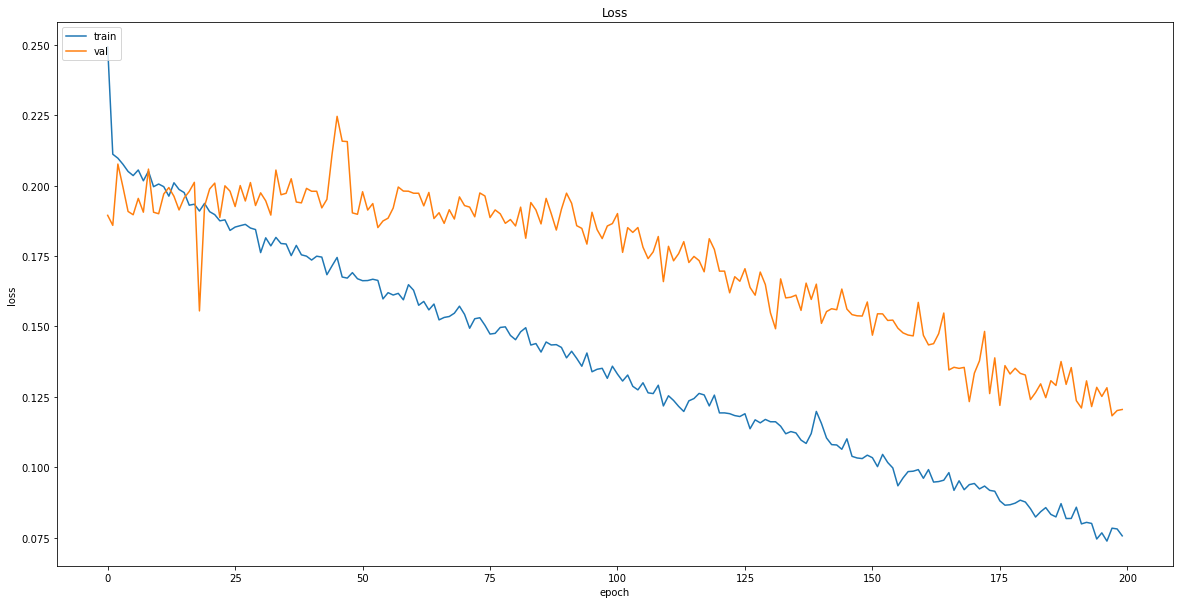

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('JBLU_no_support_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/JBLU_no_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### Non-Recession Test Data

In [28]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [29]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,17.600000,17.005903,-4.149392,23132100.0,2.0
2019-01-23,17.370001,17.061918,-14.049519,19087600.0,2.0
2019-01-24,17.240000,17.089315,-19.421466,14999400.0,2.0
2019-01-25,18.120001,17.247882,-5.555506,23032100.0,2.0
2019-01-28,17.709999,17.318977,-26.363710,14531900.0,2.0


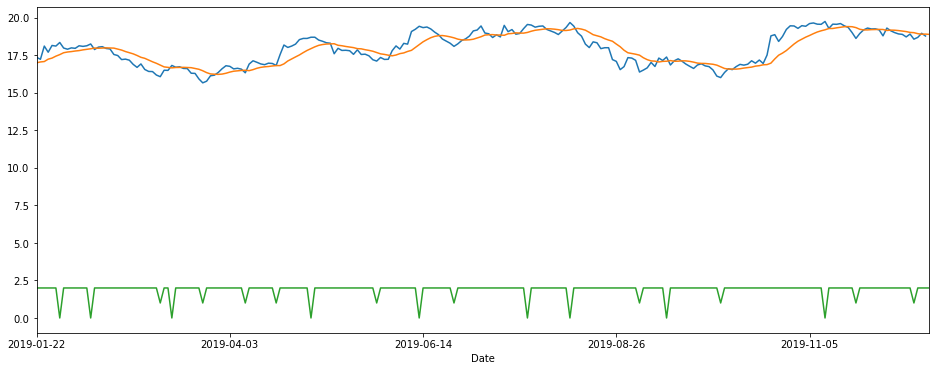

In [30]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [36]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [37]:
model = tf.keras.models.load_model("models/JBLU_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 16ms/step - loss: 0.1108 - accuracy: 0.8028 - mean_squared_error: 2.2342 - weighted_accuracy: 0.8028 - weighted_mean_squared_error: 2.2342
Test loss: 0.11080741137266159
Test accuracy: 0.8027523159980774


In [38]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 187, 1: 12, 0: 19})

In [39]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({0: 8, 2: 200, 1: 10})

In [40]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)

In [41]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,18.260000,17.940004,-24.657592,14449900.0,0.0,2,0
2019-02-12,17.889999,17.989234,-16.438351,18367600.0,2.0,2,2
2019-02-13,18.049999,17.973967,-53.508854,14230800.0,2.0,2,2
2019-02-14,18.080000,17.985665,-50.000106,18206400.0,2.0,1,2
2019-02-15,17.959999,18.000178,-46.666695,20743900.0,2.0,2,2


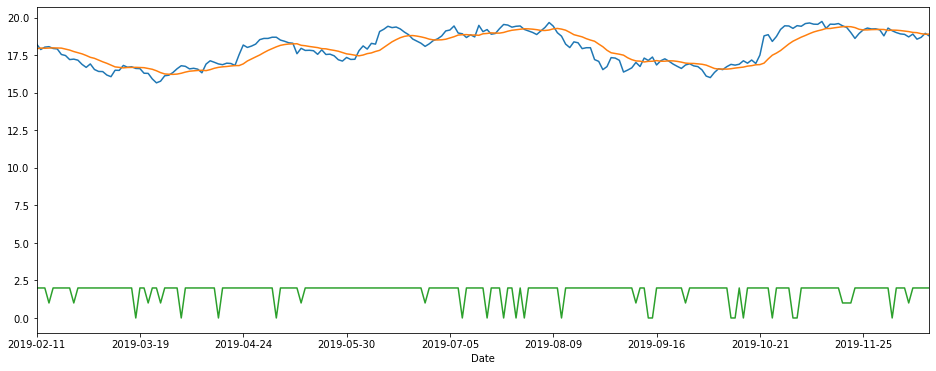

In [42]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

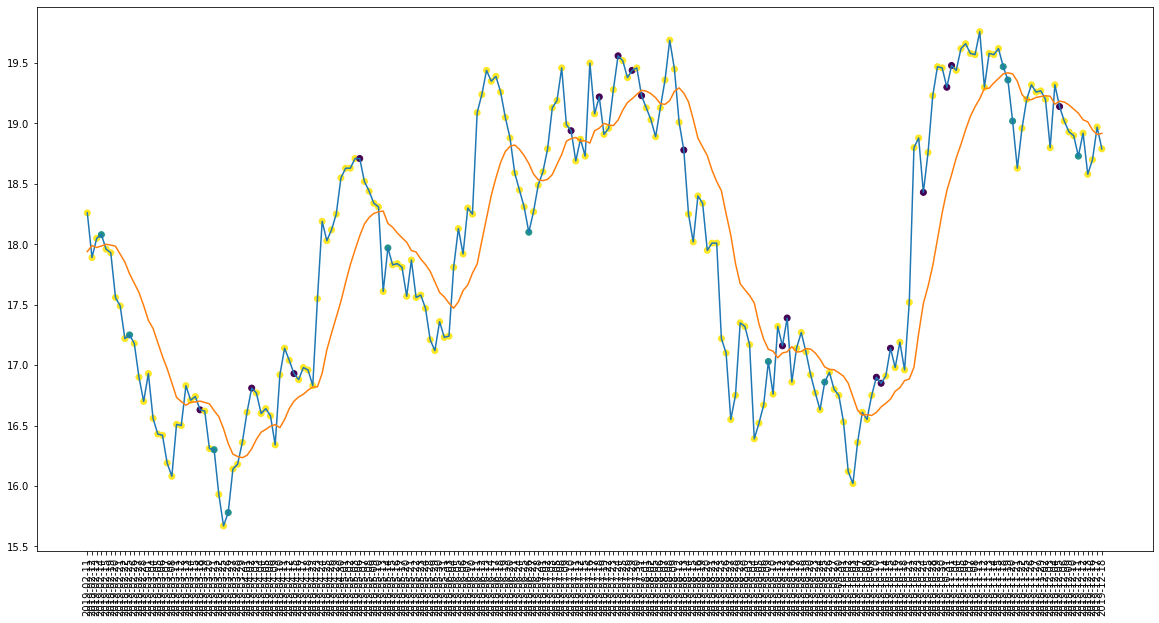

In [43]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

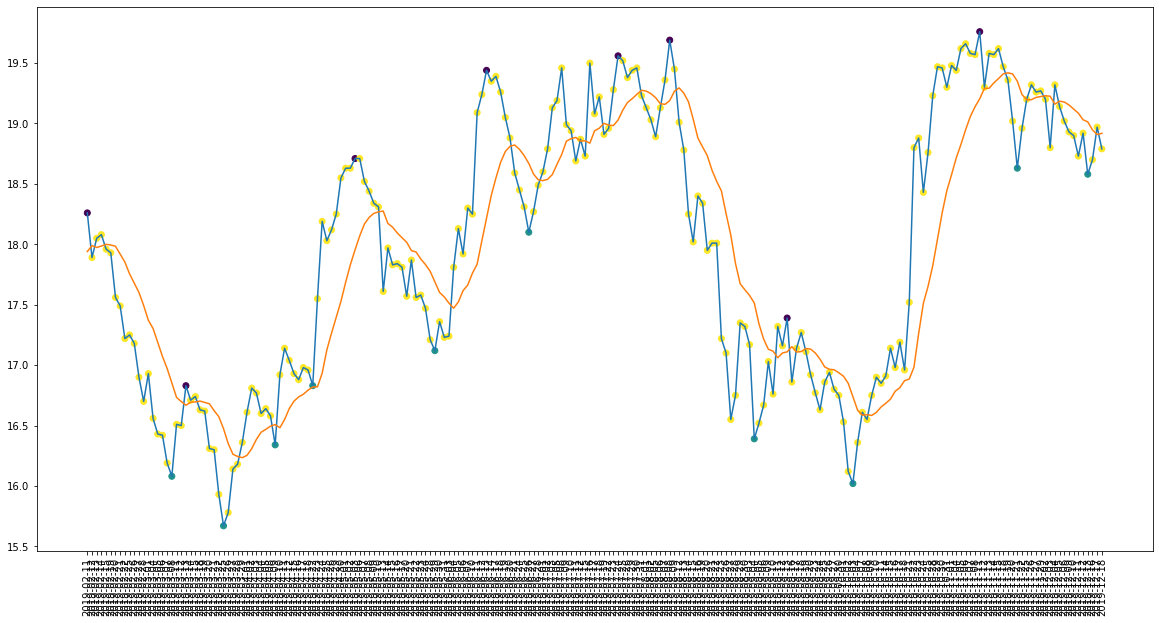

In [44]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [45]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 11
actual holds but predicted sell: 17
actual predicted holds: 172
Percentage buys correct: 10.0%
Percentage sells correct: 25.0%
Percentage holds correct: 86.0%
actual buys: 10
actual sells: 8
actual holds: 200


In [46]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[17.219999313354492, 17.489999771118164, 17.559999465942386, 17.889999389648438, 17.93000030517578, 17.959999084472656, 18.049999237060547, 18.07999992370605, 18.26000022888184]
[16.559999465942386, 16.700000762939453, 16.899999618530273, 16.930000305175778, 17.180000305175778, 17.219999313354492, 17.25, 17.489999771118164, 17.559999465942386]
Percentage buys correct: 33.333333333333336%
Percentage sells correct: 63.1578947368421%
Percentage holds correct: 83.33333333333333%


In [47]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $18.07999992370605
Shares owned at the moment: 551
Cash capital at the moment: $10.524322153569301


Stop Loss Activated!

Share price: $17.559999465942386
Shares owned at the moment: 0
Cash capital at the moment: $9659.476238697054


Share price: $17.25
Shares owned at the moment: 558
Cash capital at the moment: $7.5061136970543885


Stop Loss Activated!

Share price: $16.700000762939453
Shares owned at the moment: 0
Cash capital at the moment: $9300.480388246538


Share price: $16.299999237060547
Shares owned at the moment: 569
Cash capital at the moment: $0.27539855289614934


Stop Loss Activated!

Share price: $15.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8891.98580934477


Share price: $15.779999732971193
Shares owned at the moment: 561
Cash capital at the moment: $15.061364559887807


Price increase from previously bought: 6.235101572076185%
Share price: $16.809999465942386
Shares owned at the moment: 0
Cash capital at the moment: $94

In [48]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10233.749798190114
profit gained: 2.337497981901142%


In [49]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,10.0%,25.0%,86.0%,33.333333333333336%,63.1578947368421%,83.33333333333333%,-11.85156267213586%,2.337497981901142%


### Recession test data

In [50]:
logger = []

In [51]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


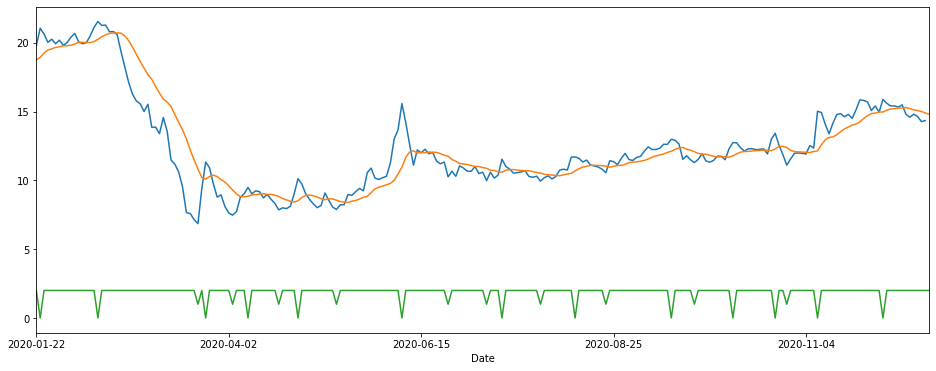

In [52]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [53]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [54]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [56]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [57]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [58]:
model = tf.keras.models.load_model("models/JBLU_no_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 14ms/step - loss: 0.1151 - accuracy: 0.7991 - mean_squared_error: 2.2280 - weighted_accuracy: 0.7991 - weighted_mean_squared_error: 2.2280
Test loss: 0.11507631838321686
Test accuracy: 0.7990867495536804


In [59]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 197, 1: 9, 0: 13})

In [60]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [61]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)

In [62]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,20.510000,20.028004,-60.309266,9053300.0,2.0,2,2
2020-02-12,21.129999,20.102157,-43.870955,13857200.0,2.0,2,2
2020-02-13,21.559999,20.260287,-12.352994,18449600.0,0.0,2,0
2020-02-14,21.270000,20.460243,-1.538496,23393200.0,2.0,2,2
2020-02-18,21.299999,20.584821,-18.905429,17925800.0,2.0,2,2


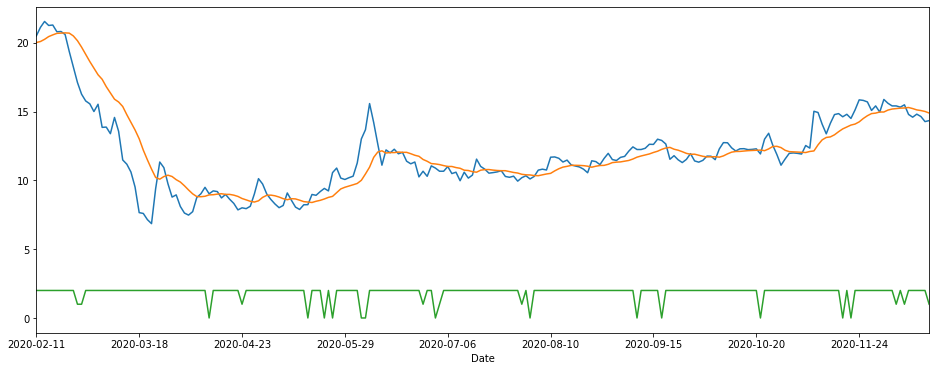

In [63]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

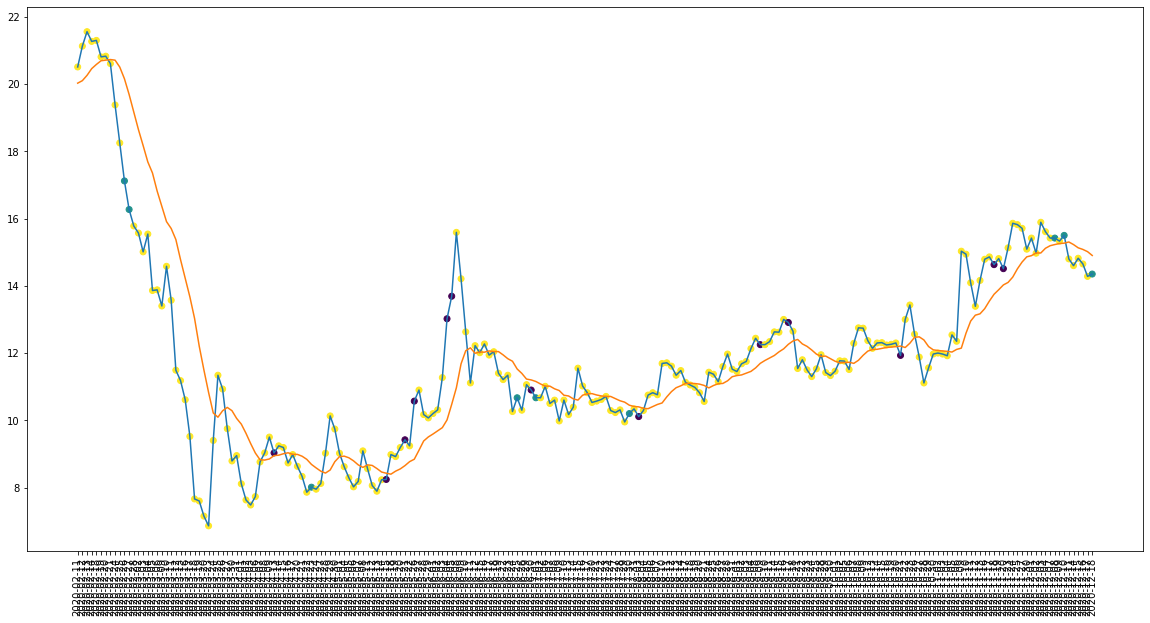

In [64]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

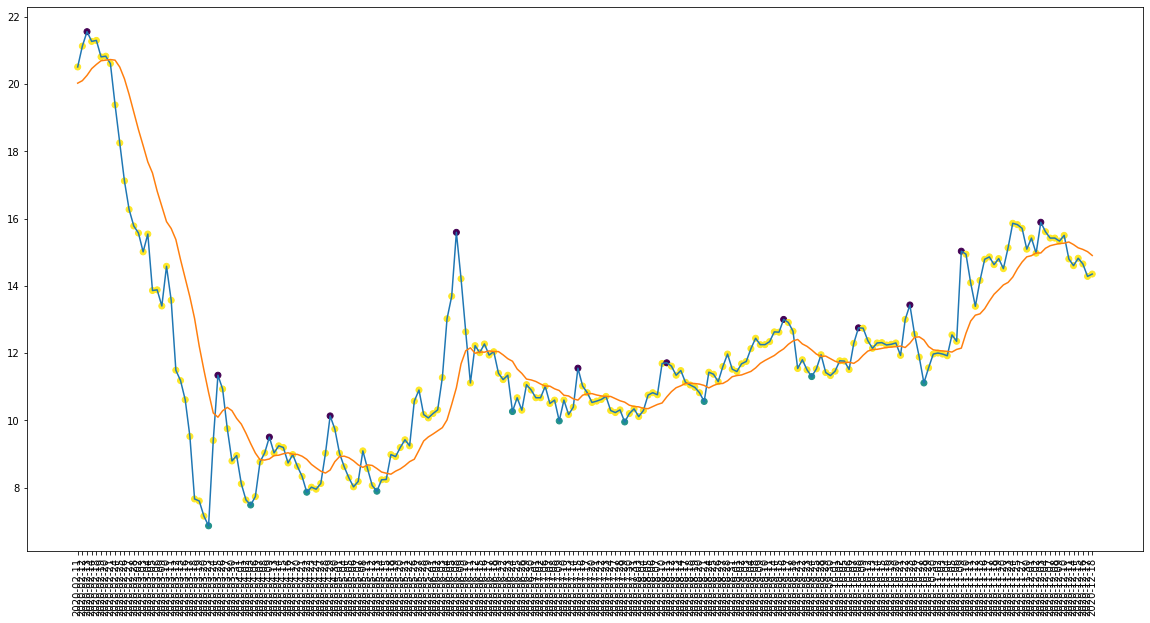

In [65]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 12
actual holds but predicted buy: 9
actual holds but predicted sell: 13
actual predicted holds: 175
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.83248730964468%
actual buys: 10
actual sells: 12
actual holds: 197


In [67]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

[19.3799991607666, 20.51000022888184, 20.61000061035156, 20.809999465942386, 20.82999992370605, 21.1299991607666, 21.270000457763672, 21.299999237060547, 21.559999465942386]
[15.010000228881836, 15.56999969482422, 15.779999732971193, 16.270000457763672, 17.120000839233402, 18.25, 19.3799991607666, 20.61000061035156, 20.82999992370605]
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 53.84615384615385%
Percentage holds correct: 83.6734693877551%


In [68]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $17.120000839233402
Shares owned at the moment: 582
Cash capital at the moment: $8.758950222967542


Stop Loss Activated!

Share price: $16.270000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9451.859080908773


Share price: $16.270000457763672
Shares owned at the moment: 579
Cash capital at the moment: $5.622907634731746


Stop Loss Activated!

Share price: $15.779999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9117.117048450229


Share price: $8.010000228881836
Shares owned at the moment: 1135
Cash capital at the moment: $0.7655754549468838


Price increase from previously bought: 17.280472547212412%
Share price: $9.420000076293944
Shares owned at the moment: 0
Cash capital at the moment: $10663.06348681044


Share price: $10.670000076293944
Shares owned at the moment: 996
Cash capital at the moment: $6.518280612703165


Stop Loss Activated!

Share price: $10.300000190734863
Shares owned at the moment: 0
Cash capital at the 

In [69]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $6959.649683341978
profit gained: -30.40350316658022%


In [70]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,10.0%,25.0%,86.0%,33.333333333333336%,63.1578947368421%,83.33333333333333%,-11.85156267213586%,2.337497981901142%
1,0.799087,0.0%,0.0%,88.83248730964468%,55.55555555555556%,53.84615384615385%,83.6734693877551%,7.979584330608831%,-30.40350316658022%


### with DAL stock price

In [71]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data.csv")
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2002-05-02,14.761481,13.724947,-5.141986,58104336.0,2.0
2002-05-03,14.562963,13.853872,-13.413429,57315261.0,2.0
2002-05-06,15.419259,14.094701,-0.086583,58757399.0,0.0
2002-05-07,16.148148,14.410616,-4.436861,61163774.0,2.0
2002-05-08,14.696296,14.454567,-37.883964,57784724.0,2.0


In [72]:
df2 = pd.read_csv("data/variation 6/initial_indicators/DAL_data.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2007-05-23,19.480000,19.446154,-62.849899,22231100.0,2.0
2007-05-24,19.209999,19.409822,-64.264305,19844000.0,2.0
2007-05-25,19.020000,19.349850,-69.418965,17482000.0,2.0
2007-05-29,18.760000,19.259104,-66.055061,16587000.0,2.0
2007-05-30,19.090000,19.233088,-50.917452,19505800.0,2.0


In [73]:
df['support'] = df2['previous_1d']
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2007-05-23,11.10,10.685789,-10.576890,-70068416.0,2.0,19.480000
2007-05-24,10.90,10.718745,-32.978783,-75520116.0,2.0,19.209999
2007-05-25,10.83,10.735861,-42.222253,-79888316.0,2.0,19.020000
2007-05-29,10.84,10.751882,-41.111116,-78160416.0,2.0,18.760000
2007-05-30,10.88,10.771593,-38.372099,-70811516.0,2.0,19.090000


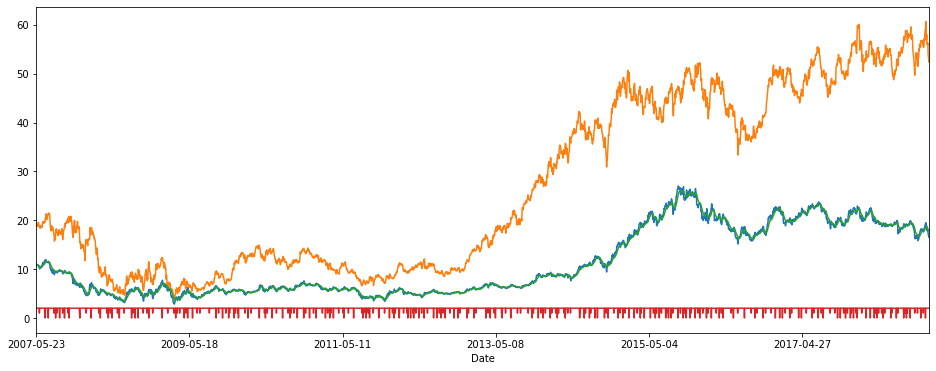

In [74]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [75]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    n = support_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)
    ax.plot(n)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [77]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(2902, 64, 64, 1)

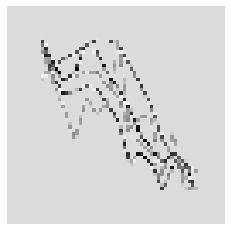

In [78]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [79]:
X = X/255

In [80]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [81]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [82]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [84]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.29874213836478, 1: 7.439102564102564, 2: 0.36649297331438496}
Epoch 1/200
19/19 [==============================] - 2s 125ms/step - loss: 0.2617 - accuracy: 0.4024 - mse: 1.8939 - weighted_accuracy: 0.3614 - weighted_mse: 1.9813 - val_loss: 0.2153 - val_accuracy: 0.0620 - val_mse: 0.8033 - val_weighted_accuracy: 0.0620 - val_weighted_mse: 0.8033
Epoch 2/200
19/19 [==============================] - 0s 12ms/step - loss: 0.2119 - accuracy: 0.2848 - mse: 1.2416 - weighted_accuracy: 0.2894 - weighted_mse: 1.2387 - val_loss: 0.2179 - val_accuracy: 0.0482 - val_mse: 0.9256 - val_weighted_accuracy: 0.0482 - val_weighted_mse: 0.9256
Epoch 3/200
19/19 [==============================] - 0s 12ms/step - loss: 0.2053 - accuracy: 0.3516 - mse: 1.1481 - weighted_accuracy: 0.3350 - weighted_mse: 1.1697 - val_loss: 0.2056 - val_accuracy: 0.0448 - val_mse: 0.9647 - val_weighted_accuracy: 0.0448 - val_weighted_mse: 0.9647
Epoch 4/200
19/19 [==============================] - 0s 11ms/step - loss: 0.204

19/19 [==============================] - 0s 12ms/step - loss: 0.1966 - accuracy: 0.2844 - mse: 1.2021 - weighted_accuracy: 0.4189 - weighted_mse: 1.1902 - val_loss: 0.1918 - val_accuracy: 0.0654 - val_mse: 1.0429 - val_weighted_accuracy: 0.0654 - val_weighted_mse: 1.0429
Epoch 29/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1950 - accuracy: 0.3145 - mse: 1.2697 - weighted_accuracy: 0.4623 - weighted_mse: 1.2379 - val_loss: 0.1919 - val_accuracy: 0.2134 - val_mse: 1.1960 - val_weighted_accuracy: 0.2134 - val_weighted_mse: 1.1960
Epoch 30/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1967 - accuracy: 0.3654 - mse: 1.1467 - weighted_accuracy: 0.4176 - weighted_mse: 1.1379 - val_loss: 0.1976 - val_accuracy: 0.0688 - val_mse: 1.0649 - val_weighted_accuracy: 0.0688 - val_weighted_mse: 1.0649
Epoch 31/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1979 - accuracy: 0.2693 - mse: 1.2391 - weighted_accuracy: 0.4133 - weighted_mse:

Epoch 57/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1862 - accuracy: 0.3167 - mse: 1.2079 - weighted_accuracy: 0.4914 - weighted_mse: 1.1856 - val_loss: 0.1930 - val_accuracy: 0.1222 - val_mse: 1.1195 - val_weighted_accuracy: 0.1222 - val_weighted_mse: 1.1195
Epoch 58/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1876 - accuracy: 0.2012 - mse: 1.3063 - weighted_accuracy: 0.4515 - weighted_mse: 1.2772 - val_loss: 0.1968 - val_accuracy: 0.1222 - val_mse: 1.0728 - val_weighted_accuracy: 0.1222 - val_weighted_mse: 1.0728
Epoch 59/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1823 - accuracy: 0.3046 - mse: 1.2927 - weighted_accuracy: 0.4928 - weighted_mse: 1.2435 - val_loss: 0.1985 - val_accuracy: 0.0912 - val_mse: 1.0622 - val_weighted_accuracy: 0.0912 - val_weighted_mse: 1.0622
Epoch 60/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1796 - accuracy: 0.2322 - mse: 1.2872 - weighted_accuracy: 0.5230 - 

Epoch 86/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1667 - accuracy: 0.2632 - mse: 1.4030 - weighted_accuracy: 0.5646 - weighted_mse: 1.3552 - val_loss: 0.1955 - val_accuracy: 0.2169 - val_mse: 1.1282 - val_weighted_accuracy: 0.2169 - val_weighted_mse: 1.1282
Epoch 87/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1703 - accuracy: 0.2865 - mse: 1.3296 - weighted_accuracy: 0.5434 - weighted_mse: 1.3189 - val_loss: 0.1979 - val_accuracy: 0.1738 - val_mse: 1.0471 - val_weighted_accuracy: 0.1738 - val_weighted_mse: 1.0471
Epoch 88/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1695 - accuracy: 0.2628 - mse: 1.3033 - weighted_accuracy: 0.5583 - weighted_mse: 1.2619 - val_loss: 0.1944 - val_accuracy: 0.2065 - val_mse: 1.1129 - val_weighted_accuracy: 0.2065 - val_weighted_mse: 1.1129
Epoch 89/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1610 - accuracy: 0.2495 - mse: 1.3718 - weighted_accuracy: 0.5932 - 

Epoch 115/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1438 - accuracy: 0.3184 - mse: 1.5634 - weighted_accuracy: 0.6393 - weighted_mse: 1.6212 - val_loss: 0.1926 - val_accuracy: 0.2806 - val_mse: 1.1975 - val_weighted_accuracy: 0.2806 - val_weighted_mse: 1.1975
Epoch 116/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1462 - accuracy: 0.3477 - mse: 1.4092 - weighted_accuracy: 0.6439 - weighted_mse: 1.4800 - val_loss: 0.1895 - val_accuracy: 0.3201 - val_mse: 1.2433 - val_weighted_accuracy: 0.3201 - val_weighted_mse: 1.2433
Epoch 117/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1479 - accuracy: 0.3464 - mse: 1.5035 - weighted_accuracy: 0.6318 - weighted_mse: 1.5503 - val_loss: 0.1879 - val_accuracy: 0.3373 - val_mse: 1.3836 - val_weighted_accuracy: 0.3373 - val_weighted_mse: 1.3836
Epoch 118/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1474 - accuracy: 0.3585 - mse: 1.4775 - weighted_accuracy: 0.659

Epoch 144/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1278 - accuracy: 0.4946 - mse: 1.6970 - weighted_accuracy: 0.7006 - weighted_mse: 1.8472 - val_loss: 0.1691 - val_accuracy: 0.4888 - val_mse: 1.4000 - val_weighted_accuracy: 0.4888 - val_weighted_mse: 1.4000
Epoch 145/200
19/19 [==============================] - 0s 11ms/step - loss: 0.1222 - accuracy: 0.5179 - mse: 1.7014 - weighted_accuracy: 0.7394 - weighted_mse: 1.9308 - val_loss: 0.1803 - val_accuracy: 0.4131 - val_mse: 1.3841 - val_weighted_accuracy: 0.4131 - val_weighted_mse: 1.3841
Epoch 146/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1275 - accuracy: 0.4903 - mse: 1.7041 - weighted_accuracy: 0.7202 - weighted_mse: 1.8955 - val_loss: 0.1805 - val_accuracy: 0.4699 - val_mse: 1.4729 - val_weighted_accuracy: 0.4699 - val_weighted_mse: 1.4729
Epoch 147/200
19/19 [==============================] - 0s 12ms/step - loss: 0.1280 - accuracy: 0.5144 - mse: 1.6883 - weighted_accuracy: 0.705

Epoch 173/200
19/19 [==============================] - 0s 15ms/step - loss: 0.1084 - accuracy: 0.5963 - mse: 1.9278 - weighted_accuracy: 0.7801 - weighted_mse: 2.3673 - val_loss: 0.1537 - val_accuracy: 0.6213 - val_mse: 1.4878 - val_weighted_accuracy: 0.6213 - val_weighted_mse: 1.4878
Epoch 174/200
19/19 [==============================] - 0s 14ms/step - loss: 0.1072 - accuracy: 0.5980 - mse: 1.9477 - weighted_accuracy: 0.7867 - weighted_mse: 2.4095 - val_loss: 0.1439 - val_accuracy: 0.6850 - val_mse: 1.5810 - val_weighted_accuracy: 0.6850 - val_weighted_mse: 1.5810
Epoch 175/200
19/19 [==============================] - 0s 14ms/step - loss: 0.1021 - accuracy: 0.6394 - mse: 2.0379 - weighted_accuracy: 0.7899 - weighted_mse: 2.5884 - val_loss: 0.1545 - val_accuracy: 0.6024 - val_mse: 1.6221 - val_weighted_accuracy: 0.6024 - val_weighted_mse: 1.6221
Epoch 176/200
19/19 [==============================] - 0s 15ms/step - loss: 0.1108 - accuracy: 0.6165 - mse: 1.9234 - weighted_accuracy: 0.769

In [85]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13046719133853912
Test accuracy: 0.7366609573364258


In [86]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.4019046  -0.630672   -0.23946275]
 [-0.7616688  -1.2827666  -0.16099828]
 [-0.72138715 -1.9056472  -0.02000804]
 ...
 [-0.05122858 -2.4707615  -0.55883795]
 [-1.1343936  -0.6016135  -0.67365617]
 [-0.9922987  -1.6087265  -0.00267854]]


Counter({2: 460, 0: 77, 1: 44})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 529, 0: 26, 1: 26})

In [88]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 581
actual predicted buys: 4
actual buys but predicted sell: 2
actual buys but predicted hold: 20
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 21
actual holds but predicted buy: 40
actual holds but predicted sell: 70
actual predicted holds: 419
Percentage buys correct: 15.384615384615385%
Percentage sells correct: 19.23076923076923%
Percentage holds correct: 79.20604914933837%
actual buys: 26
actual sells: 26
actual holds: 529


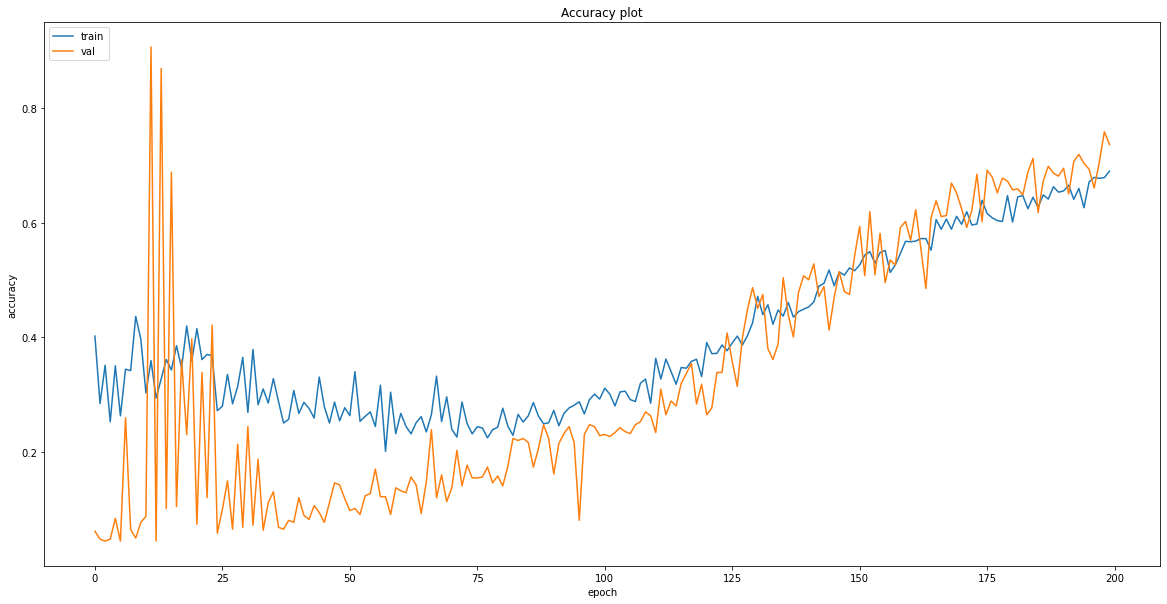

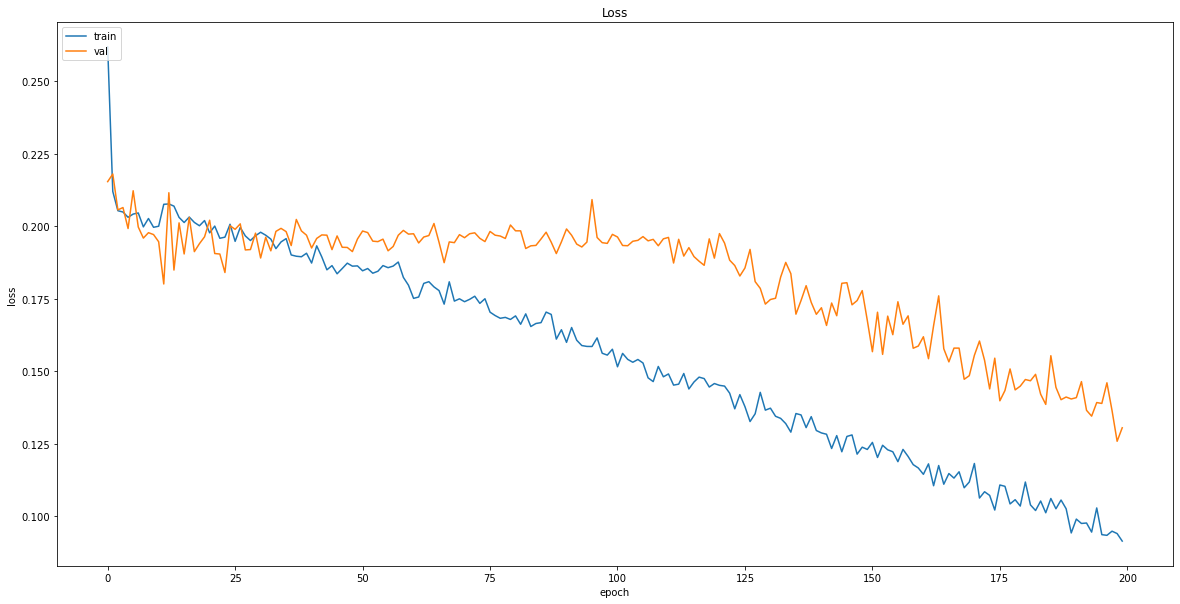

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [90]:
# Save model
model.save("models/{}".format('JBLU_support_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/JBLU_support_image_cnn_buy_hold_sell.model\assets


### Test Performance

### non-recession

In [91]:
logger = []

In [92]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22    17.600000  17.005903  -4.149392  23132100.0     2.0
2019-01-23    17.370001  17.061918 -14.049519  19087600.0     2.0
2019-01-24    17.240000  17.089315 -19.421466  14999400.0     2.0
2019-01-25    18.120001  17.247882  -5.555506  23032100.0     2.0
2019-01-28    17.709999  17.318977 -26.363710  14531900.0     2.0


In [93]:
df2 = pd.read_csv("data/variation 6/initial_indicators/DAL_data_test.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-01-22,48.110001,48.138043,-45.698927,9500900.0,1.0
2019-01-23,47.099998,47.978344,-60.236271,1356500.0,2.0
2019-01-24,47.299999,47.873983,-47.268459,9456400.0,2.0
2019-01-25,47.520000,47.819524,-51.008641,18513600.0,2.0
2019-01-28,47.689999,47.799597,-46.109560,30352800.0,2.0


In [94]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2019-01-22,17.600000,17.005903,-4.149392,23132100.0,2.0,48.110001
2019-01-23,17.370001,17.061918,-14.049519,19087600.0,2.0,47.099998
2019-01-24,17.240000,17.089315,-19.421466,14999400.0,2.0,47.299999
2019-01-25,18.120001,17.247882,-5.555506,23032100.0,2.0,47.520000
2019-01-28,17.709999,17.318977,-26.363710,14531900.0,2.0,47.689999


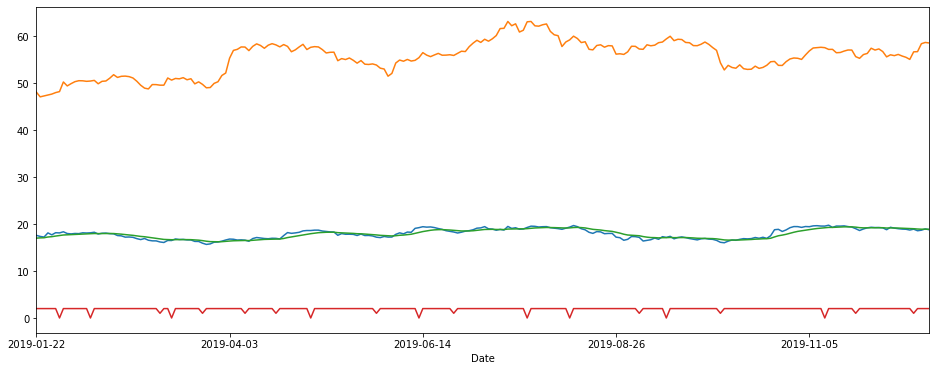

In [95]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['support'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [96]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [98]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [99]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [100]:
model = tf.keras.models.load_model("models/JBLU_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 5ms/step - loss: 0.1265 - accuracy: 0.7706 - mean_squared_error: 1.8275 - weighted_accuracy: 0.7706 - weighted_mean_squared_error: 1.8275
Test loss: 0.12650124728679657
Test accuracy: 0.7706422209739685


In [101]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 1: 23, 0: 18})

In [102]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({0: 8, 2: 200, 1: 10})

In [103]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test.csv")
df.set_index('Date', inplace=True)

In [104]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,18.260000,17.940004,-24.657592,14449900.0,0.0,2,0
2019-02-12,17.889999,17.989234,-16.438351,18367600.0,2.0,2,2
2019-02-13,18.049999,17.973967,-53.508854,14230800.0,2.0,2,2
2019-02-14,18.080000,17.985665,-50.000106,18206400.0,2.0,1,2
2019-02-15,17.959999,18.000178,-46.666695,20743900.0,2.0,2,2


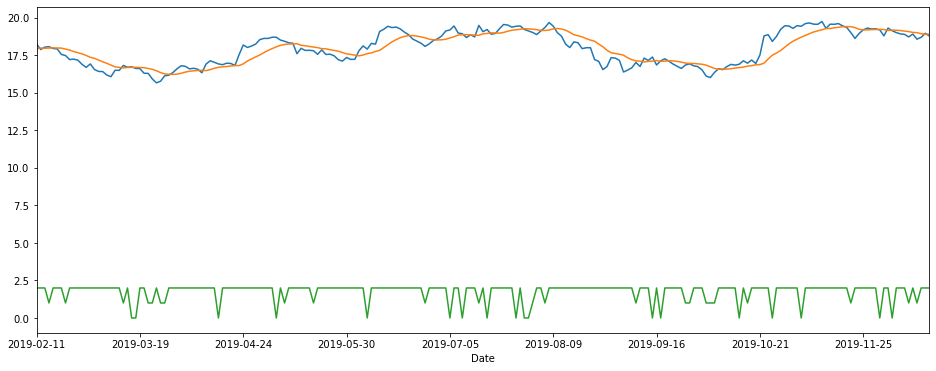

In [105]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

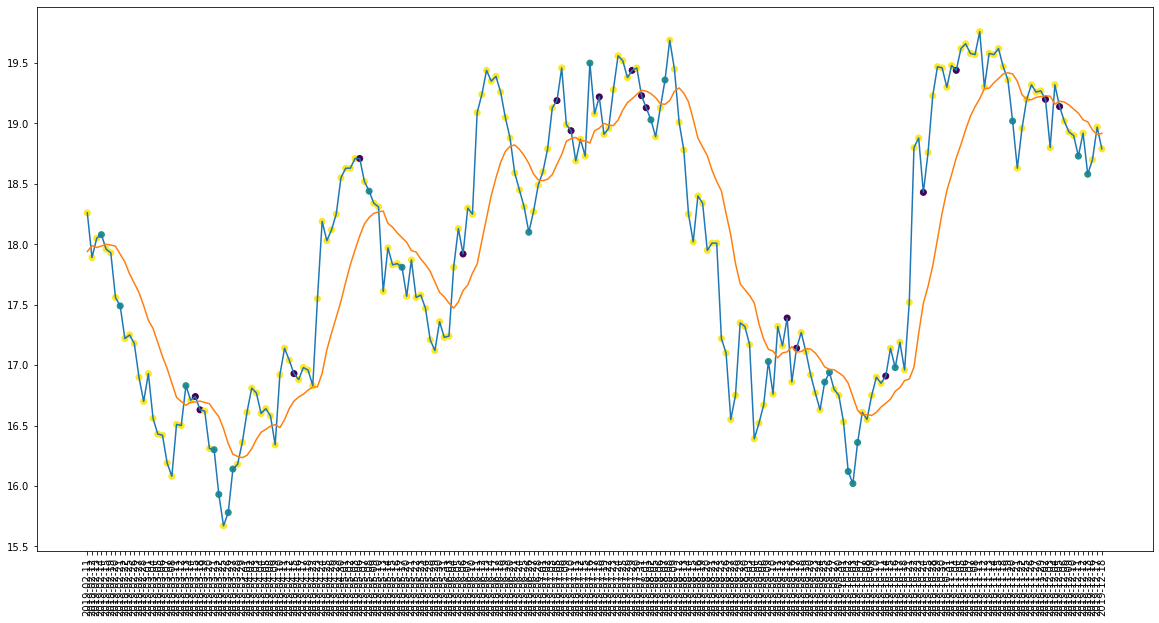

In [106]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

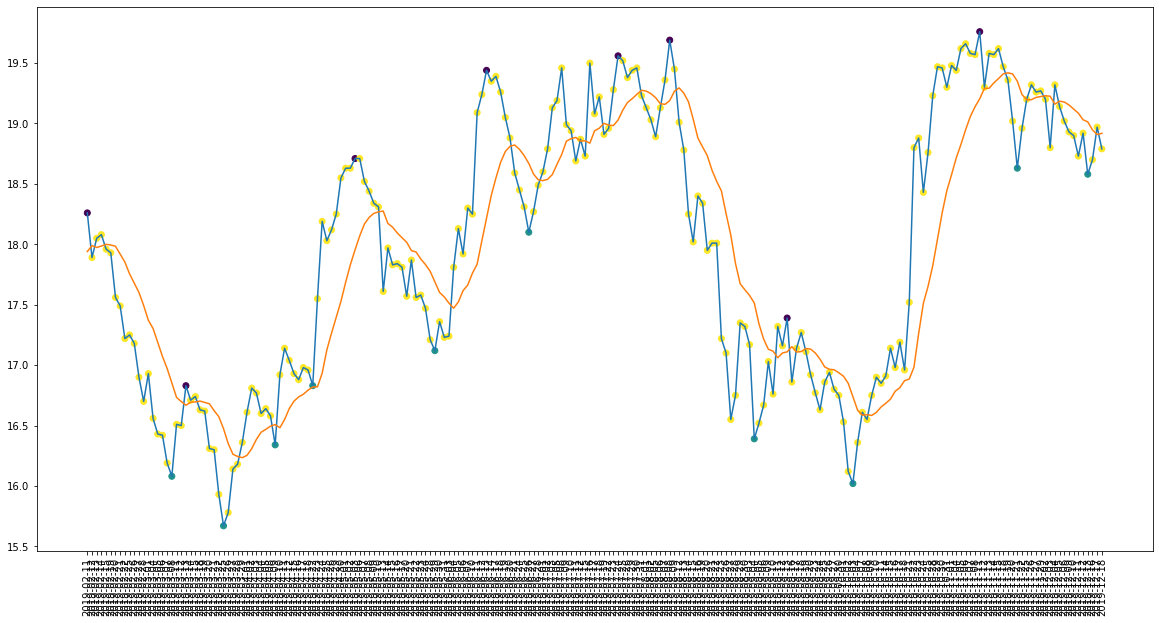

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [108]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 6
actual holds but predicted buy: 19
actual holds but predicted sell: 17
actual predicted holds: 164
Percentage buys correct: 30.0%
Percentage sells correct: 12.5%
Percentage holds correct: 82.0%
actual buys: 10
actual sells: 8
actual holds: 200
[17.219999313354492, 17.489999771118164, 17.559999465942386, 17.889999389648438, 17.93000030517578, 17.959999084472656, 18.049999237060547, 18.07999992370605, 18.26000022888184]
[16.559999465942386, 16.700000762939453, 16.899999618530273, 16.930000305175778, 17.180000305175778, 17.219999313354492, 17.25, 17.489999771118164, 17.559999465942386]
Percentage buys correct: 47.82608695652174%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 84.0909090909091%


In [109]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $18.07999992370605
Shares owned at the moment: 551
Cash capital at the moment: $10.524322153569301


Stop Loss Activated!

Share price: $17.559999465942386
Shares owned at the moment: 0
Cash capital at the moment: $9659.476238697054


Share price: $17.489999771118164
Shares owned at the moment: 550
Cash capital at the moment: $13.522739928246665


Stop Loss Activated!

Share price: $16.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $9282.961280696869


Share price: $16.829999923706055
Shares owned at the moment: 550
Cash capital at the moment: $1.0059477739323484


Stop Loss Activated!

Share price: $16.309999465942386
Shares owned at the moment: 0
Cash capital at the moment: $8946.836779850006


Share price: $16.299999237060547
Shares owned at the moment: 547
Cash capital at the moment: $6.217923325537413


Stop Loss Activated!

Share price: $15.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8554.13636744356


Share p

In [110]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10233.749798190114
profit gained: 2.337497981901142%


In [111]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,10.0%,25.0%,86.0%,33.333333333333336%,63.1578947368421%,83.33333333333333%,-11.85156267213586%,2.337497981901142%
1,0.799087,0.0%,0.0%,88.83248730964468%,55.55555555555556%,53.84615384615385%,83.6734693877551%,7.979584330608831%,-30.40350316658022%
2,0.770642,30.0%,12.5%,82.0%,47.82608695652174%,44.44444444444444%,84.0909090909091%,-12.86758052671448%,2.337497981901142%


### Recession

In [112]:
logger = []

In [113]:
seed = 10
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    19.049999  18.785034 -29.629734  -5172900.0     2.0
2020-01-23    19.790001  18.939644 -15.920381   7229600.0     0.0
2020-01-24    21.070000  19.267391  -2.622949  23219300.0     2.0
2020-01-27    20.650000  19.480100 -18.060233  11950900.0     2.0
2020-01-28    20.040001  19.566239 -38.461529   3416600.0     2.0


In [114]:
df2 = pd.read_csv("data/variation 6/initial_indicators/DAL_data_test2.csv")
df2.set_index('Date', inplace=True)
df2.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-01-22,60.340000,59.859537,-36.769751,36316500.0,2.0
2020-01-23,59.639999,59.825762,-48.797256,29220100.0,2.0
2020-01-24,60.270000,59.894106,-37.972495,36994600.0,2.0
2020-01-27,58.810001,59.727321,-63.058391,26005100.0,2.0
2020-01-28,56.830002,59.281579,-82.361475,12914900.0,2.0


In [115]:
df['support'] = df2['previous_1d']
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,support
Date,,,,,,
2020-01-22,19.049999,18.785034,-29.629734,-5172900.0,2.0,60.340000
2020-01-23,19.790001,18.939644,-15.920381,7229600.0,0.0,59.639999
2020-01-24,21.070000,19.267391,-2.622949,23219300.0,2.0,60.270000
2020-01-27,20.650000,19.480100,-18.060233,11950900.0,2.0,58.810001
2020-01-28,20.040001,19.566239,-38.461529,3416600.0,2.0,56.830002


In [116]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
support_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
data_15_support = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        data_15_support_arr = min_max_scaler.fit_transform(data_15_support)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        support_data.append(data_15_support_arr)
        labels.append(i[4])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
        data_15_support = data_15_support[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        data_15_support.append([i[-1]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)
support_data = np.array(support_data)

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [118]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [119]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [120]:
model = tf.keras.models.load_model("models/JBLU_support_image_cnn_buy_hold_sell.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]) ; logger.append(score[1]) 

7/7 [==============================] - 0s 6ms/step - loss: 0.1313 - accuracy: 0.7534 - mean_squared_error: 1.9025 - weighted_accuracy: 0.7534 - weighted_mean_squared_error: 1.9025
Test loss: 0.13134868443012238
Test accuracy: 0.7534246444702148


In [121]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 177, 1: 17, 0: 25})

In [122]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 197, 0: 12, 1: 10})

In [123]:
df = pd.read_csv("data/variation 6/initial_indicators/JBLU_data_test2.csv")
df.set_index('Date', inplace=True)

In [124]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,20.510000,20.028004,-60.309266,9053300.0,2.0,2,2
2020-02-12,21.129999,20.102157,-43.870955,13857200.0,2.0,2,2
2020-02-13,21.559999,20.260287,-12.352994,18449600.0,0.0,2,0
2020-02-14,21.270000,20.460243,-1.538496,23393200.0,2.0,2,2
2020-02-18,21.299999,20.584821,-18.905429,17925800.0,2.0,2,2


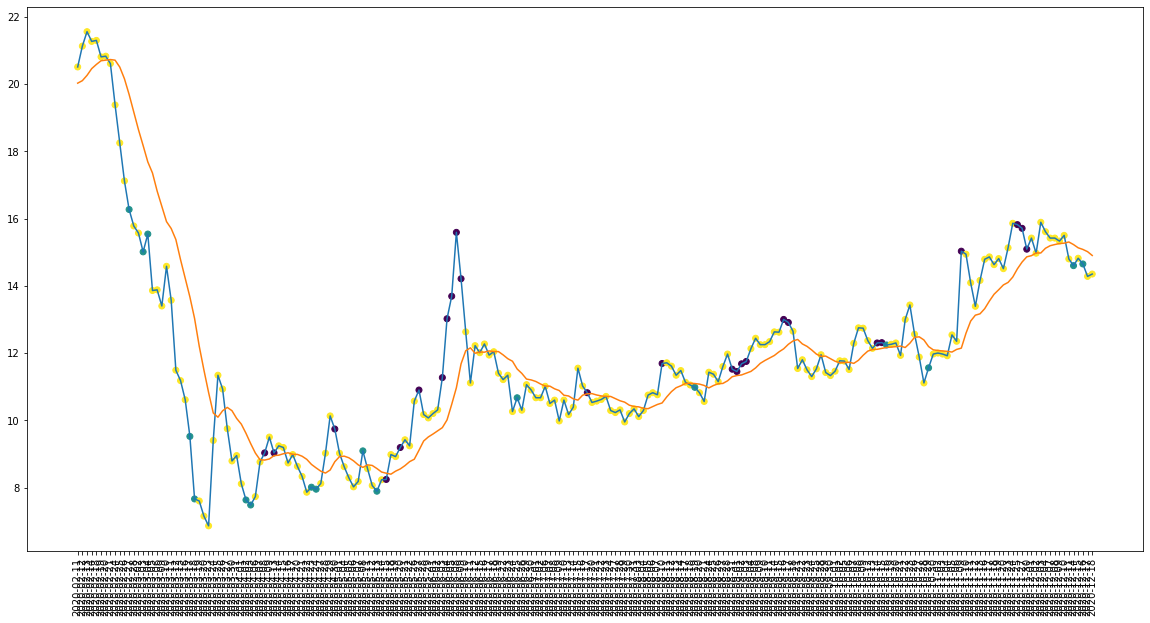

In [125]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

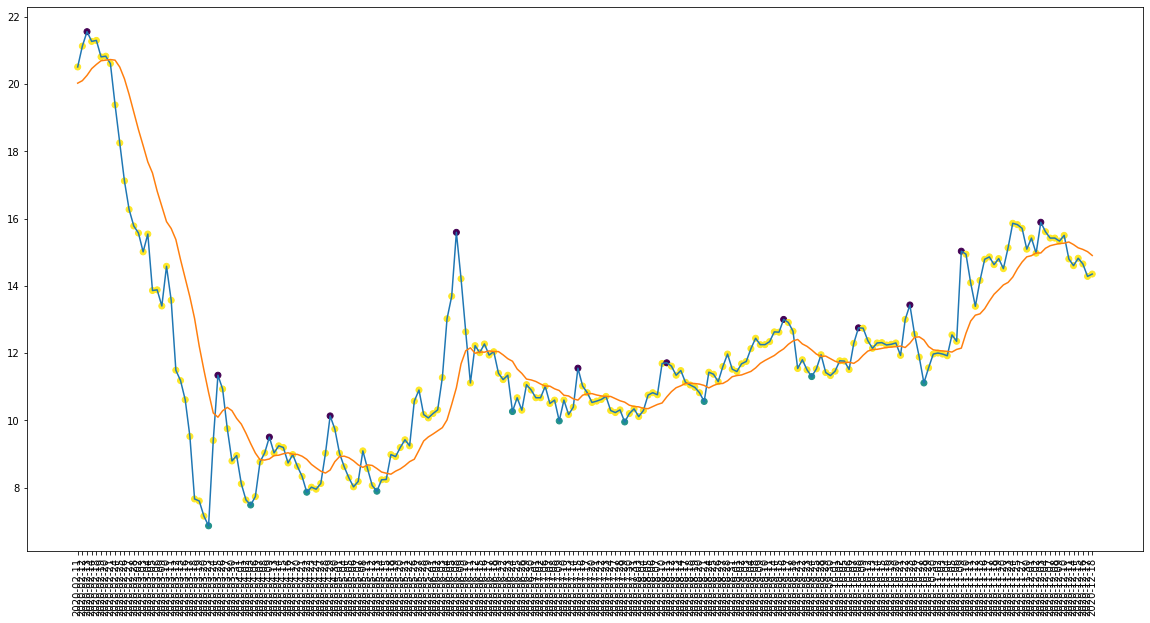

In [126]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [127]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold)) ; logger.append(str(100*buy_buy/buy) + "%") ; logger.append(str(100*sell_sell/sell) + "%") ; logger.append(str(100*hold_hold/hold) + "%")

correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%") ; logger.append(str(100*correct_minima/buy) + "%") ; logger.append(str(100*correct_maxima/sell) + "%") ; logger.append(str(100*correct_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 9
actual holds but predicted buy: 15
actual holds but predicted sell: 22
actual predicted holds: 160
Percentage buys correct: 20.0%
Percentage sells correct: 25.0%
Percentage holds correct: 81.21827411167513%
actual buys: 10
actual sells: 12
actual holds: 197
[19.3799991607666, 20.51000022888184, 20.61000061035156, 20.809999465942386, 20.82999992370605, 21.1299991607666, 21.270000457763672, 21.299999237060547, 21.559999465942386]
[15.010000228881836, 15.56999969482422, 15.779999732971193, 16.270000457763672, 17.120000839233402, 18.25, 19.3799991607666, 20.61000061035156, 20.82999992370605]
Percentage buys correct: 76.47058823529412%
Percentage sells correct: 64.0%
Percentage holds correct: 85.22727272727273%


In [128]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $16.270000457763672
Shares owned at the moment: 612
Cash capital at the moment: $15.377309078216058


Stop Loss Activated!

Share price: $15.779999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9646.179406105995


Share price: $15.010000228881836
Shares owned at the moment: 640
Cash capital at the moment: $13.36165921878819


Stop Loss Activated!

Share price: $13.859999656677244
Shares owned at the moment: 0
Cash capital at the moment: $8859.36784009647


Share price: $9.520000457763672
Shares owned at the moment: 928
Cash capital at the moment: $0.512374123571135


Stop Loss Activated!

Share price: $7.6599998474121085
Shares owned at the moment: 0
Cash capital at the moment: $7089.443912911412


Share price: $7.6599998474121085
Shares owned at the moment: 922
Cash capital at the moment: $7.502123984334503


Stop Loss Activated!

Share price: $7.1500000953674325
Shares owned at the moment: 0
Cash capital at the moment: $6581.673386671303


Share pri

In [129]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%') ; logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $6959.649683341978
profit gained: -30.40350316658022%


In [130]:
df_length = len(log)
log.loc[df_length] = logger
log.head()

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.802752,10.0%,25.0%,86.0%,33.333333333333336%,63.1578947368421%,83.33333333333333%,-11.85156267213586%,2.337497981901142%
1,0.799087,0.0%,0.0%,88.83248730964468%,55.55555555555556%,53.84615384615385%,83.6734693877551%,7.979584330608831%,-30.40350316658022%
2,0.770642,30.0%,12.5%,82.0%,47.82608695652174%,44.44444444444444%,84.0909090909091%,-12.86758052671448%,2.337497981901142%
3,0.753425,20.0%,25.0%,81.21827411167513%,76.47058823529412%,64.0%,85.22727272727273%,13.806017991840763%,-30.40350316658022%


In [131]:
experiment

'JBLU Variation 6 CNN Images Experiment'

In [132]:
log.to_csv('{}.csv'.format(experiment))